# Urban Cycling Dynamics: A Comprehensive Analysis of Bike Counts in Germany — Part 2

## Holt-Winters Munich

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
from datetime import datetime

## Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from matplotlib.pylab import rcParams

## Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


RANDOM_SEED = np.random.seed(0)
rcParams['figure.figsize'] = 10, 6

muc_2015 = "./munich2015.csv"
muc_2016 = "./munich2016.csv"
muc_2017 = "./munich2017.csv"
muc_2018 = "./munich2018.csv"
muc_2019 = "./munich2019.csv"
muc_2020 = "./munich2020.csv"
muc_2021 = "./munich2021.csv"
muc_2022 = "./munich2022.csv"

df_muc_2015 = pd.read_csv(muc_2015)
df_muc_2016 = pd.read_csv(muc_2016)
df_muc_2017 = pd.read_csv(muc_2017)
df_muc_2018 = pd.read_csv(muc_2018)
df_muc_2019 = pd.read_csv(muc_2019)
df_muc_2020 = pd.read_csv(muc_2020)
df_muc_2021 = pd.read_csv(muc_2021)
df_muc_2022 = pd.read_csv(muc_2022)

df_munich = pd.concat([df_muc_2015,df_muc_2016,df_muc_2017,df_muc_2018,df_muc_2019,df_muc_2020,df_muc_2021,df_muc_2022], ignore_index=True)

# Since all the values of the column Uhrzeit start and end are always the same, they are not really needed for the analysis, we then will drop these columns
# List of columns to drop
columns_to_drop = ['uhrzeit_start', 'uhrzeit_ende', 'kommentar', 'richtung_1', 'richtung_2', 'bewoelkung', 'sonnenstunden']

df_munich = df_munich.rename(columns={
    'datum':'Date',
    'zaehlstelle': 'Location',
    'gesamt':'Total',
    'min.temp':'MinTemp',
    'max.temp':'MaxTemp',
    'niederschlag':'RainfallVolume'})

# Drop the specified columns
df_munich = df_munich.drop(columns=columns_to_drop)
df_munich = df_munich.sort_values(by='Date')

df_munich['Date'] = pd.to_datetime(df_munich['Date'])
# Calculate average temperature
df_munich['AvgTemp'] = (df_munich['MinTemp'] + df_munich['MaxTemp']) / 2
# Get list of unique locations names
unique_locations = df_munich['Location'].unique()
print(unique_locations)
df_munich.info()

['Arnulf' 'Olympia' 'Hirsch' 'Kreuther' 'Margareten' 'Erhardt']
<class 'pandas.core.frame.DataFrame'>
Index: 17501 entries, 0 to 17500
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            17501 non-null  datetime64[ns]
 1   Location        17501 non-null  object        
 2   Total           17051 non-null  float64       
 3   MinTemp         17501 non-null  float64       
 4   MaxTemp         17501 non-null  float64       
 5   RainfallVolume  17501 non-null  float64       
 6   AvgTemp         17501 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.1+ MB


In [19]:
df_location_erhardt = df_munich[df_munich['Location']=='Erhardt'].reset_index()
df_location_erhardt.to_csv('Erhardt_Years.csv', index = True)
df_location_erhardt = df_location_erhardt[['Date','Total']]

df_location_erhardt['Date'] = pd.to_datetime(df_location_erhardt['Date'])

df_m_e_model = df_location_erhardt.set_index(['Date'])

df_m_e_model.index.freq = 'D'

In [20]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_m_e_model['Total'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

from statsmodels.tsa.stattools import kpss

# Perform KPSS test
result = kpss(df_m_e_model)

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Results of Dickey Fuller Test:
Test Statistic                   -3.669835
p-value                           0.004558
#Lags Used                       28.000000
Number of Observations Used    2893.000000
Critical Value (1%)              -3.432612
Critical Value (5%)              -2.862540
Critical Value (10%)             -2.567302
dtype: float64
Test Statistic: 1.113281649902229
P-value: 0.01


/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/ipykernel_46713/3326370206.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df_m_e_model)


## Notes:
The Augmented Dickey-Fuller (ADF) test result suggests that the time series is  **stationary**, as indicated by a p-value less than 0.05, which means that we likely don't need to difference the data to make it stationary. However, the KPSS test result suggests the presence of a trend in your series, which is something to keep in mind as we model.

## Next Steps in Modeling
### Seasonality and Trend Decomposition: 
Before diving into modeling, it might be helpful to decompose the time series into trend, seasonal, and residual components using seasonal_decompose. <br> 
This can give insights into the nature of the underlying patterns in the data, such as regular seasonal effects or long-term trends, which can influence the choice of model.

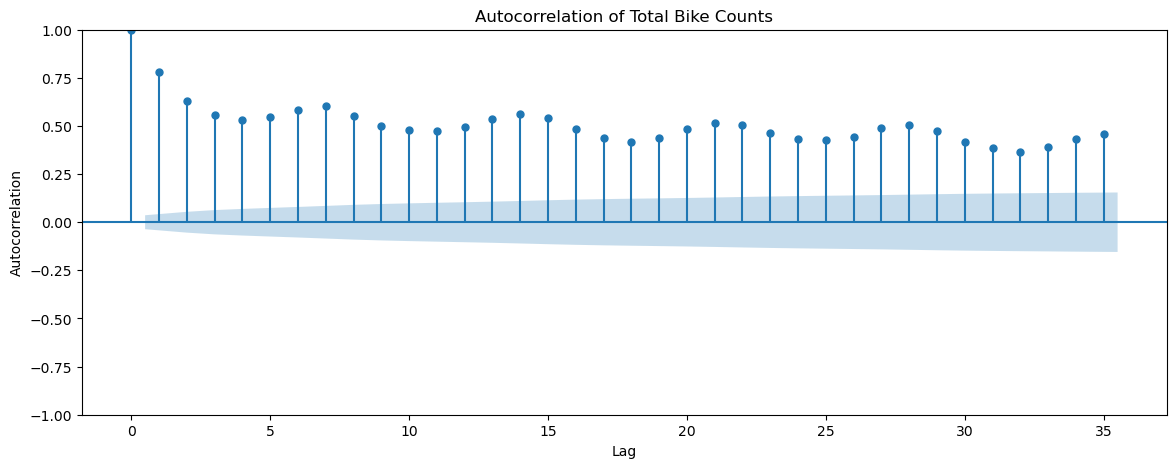

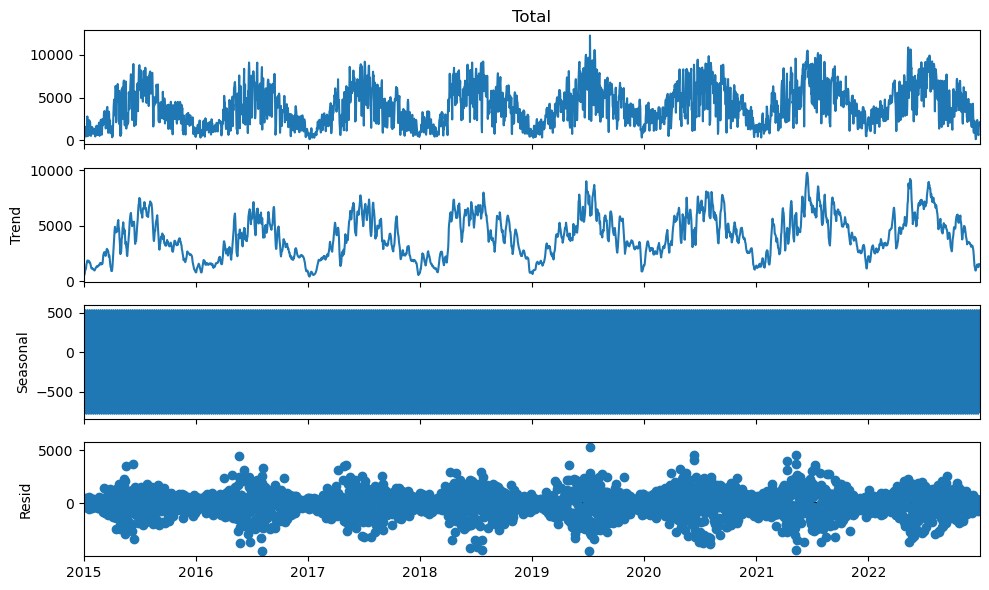

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(14, 5))

plot_acf(df_m_e_model, ax=ax, title='Autocorrelation of Total Bike Counts')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

## Some notes from Medium:
# The coefficient of correlation between two values in a time series is called the autocorrelation function (ACF). In other words,
# >Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.
# >Autocorrelation measures the relationship between a variable’s current value and its past values.
# >An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.
# Important note: make sure your data doesn’t have NA values, otherwise the ACF will fail.

res = seasonal_decompose(df_m_e_model['Total'], model = "additive",period = 7)
res.plot()
plt.show()

In [8]:
# Following: https://mlpills.dev/time-series/how-to-train-a-sarima-model-step-by-step/

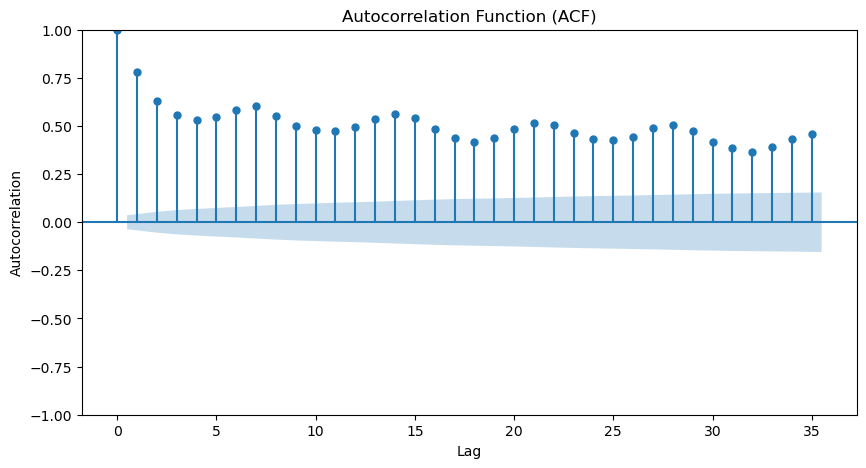

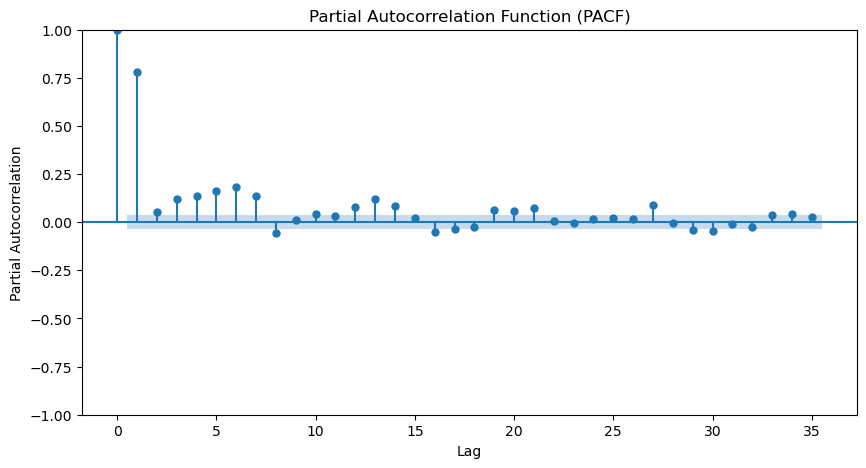

In [10]:
# Plot ACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df_m_e_model, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df_m_e_model, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [699]:
# Now time_series is a pandas Series containing the time series data
time_series = df_m_e_model['Total']

# Define the order for ARIMA model (p, d, q)
order = (1, 1, 35) 

# Instantiate ARIMA model
arima_model = ARIMA(time_series, order=order)

# Fit ARIMA model
arima_fit = arima_model.fit()

predictions = arima_fit.predict()

# Print summary of the model
print(arima_fit.summary())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2015-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   2922 non-null   float64
dtypes: float64(1)
memory usage: 45.7 KB


/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 2922
Model:                ARIMA(1, 1, 35)   Log Likelihood              -25099.284
Date:                Fri, 15 Mar 2024   AIC                          50272.568
Time:                        19:28:28   BIC                          50493.816
Sample:                    01-01-2015   HQIC                         50352.258
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0060      0.260     -0.023      0.981      -0.516       0.504
ma.L1         -0.3756      0.259     -1.448      0.148      -0.884       0.133
ma.L2         -0.2618      0.102     -2.578      0.0

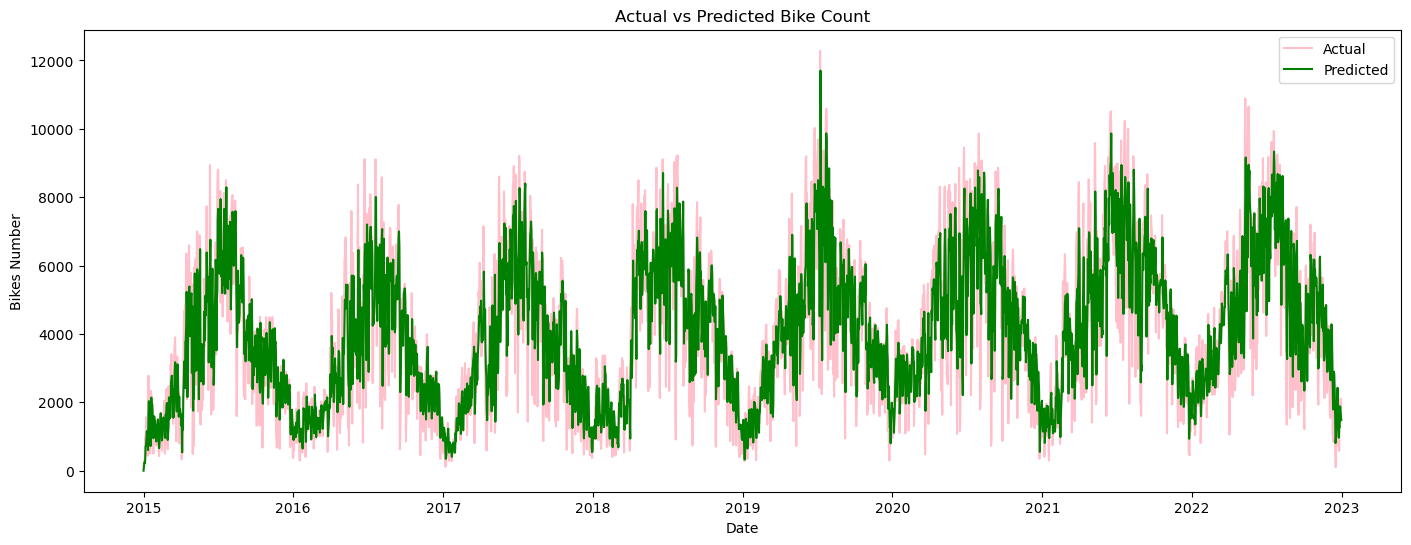

In [700]:
# Plot actual values and predictions
plt.figure(figsize=(17, 6))
plt.plot(time_series, label='Actual', color='pink')
plt.plot(predictions, color='green', label='Predicted')
plt.title('Actual vs Predicted Bike Count')
plt.xlabel('Date')
plt.ylabel('Bikes Number')
plt.legend()
plt.show()

### Holt-Winter Forecasting Model
https://medium.com/analytics-vidhya/holt-winters-forecasting-13c2e60d983f

#### Fitting the Data with Holt-Winters Exponential Smoothing

Date
2022-01-01    2186.0
2022-01-02    2701.0
2022-01-03    2547.0
2022-01-04    2157.0
2022-01-05    1948.0
Name: Total, dtype: float64


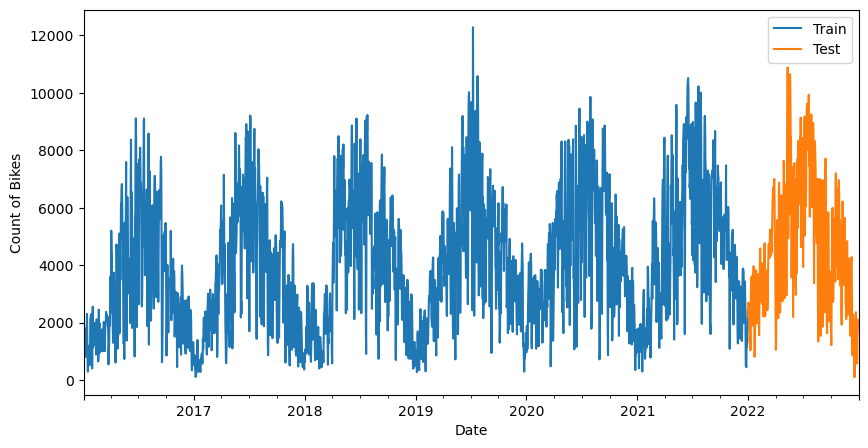

/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Axes: title={'center': 'Holt-Winters Method Single Exponential Smoothing'}, xlabel='Date'>

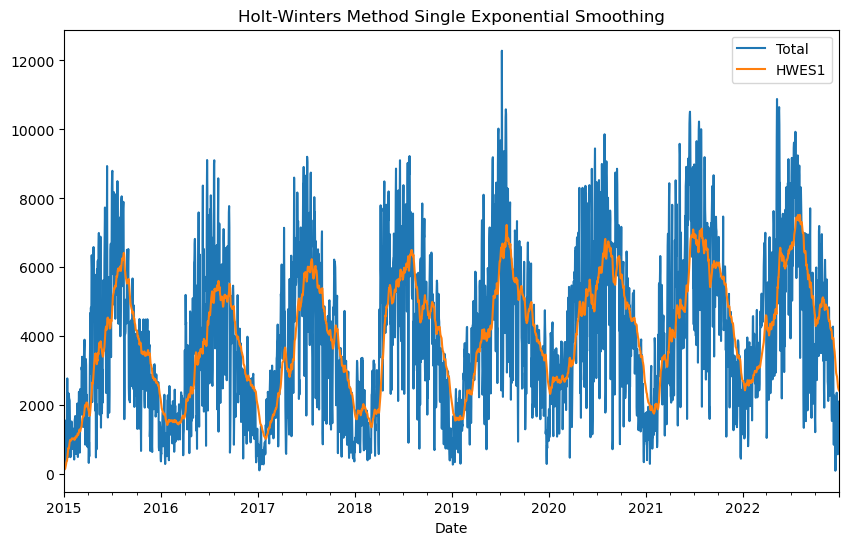

In [701]:
# Split into training and testing
df_train = df_m_e_model['Total'].iloc[:len(df_m_e_model) - 365]
df_test = df_m_e_model['Total'].iloc[len(df_m_e_model) - 365:]

print(df_test.head())

# Plot the last 6 years of training data and the testing data
ax = df_train[-6*365:].plot(figsize=(10, 5))
df_test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Count of Bikes')
plt.show()

# df_m_e_model.index = pd.to_datetime(df_m_e_model.index)

# # Check the inferred frequency of the index
# inferred_freq = df_m_e_model.index.freq
# print("Inferred frequency:", inferred_freq)

# # Set the frequency of the index to 'MS' for Month Start if the inferred frequency matches
# if inferred_freq != 'MS':
#     df_m_e_model = df_m_e_model.asfreq('MS')

m = 12
alpha = 1/(2*m)

#airline[[‘Thousands of Passengers’,’HWES1']].plot(title=’Holt Winters Single Exponential Smoothing’);
         
df_m_e_model['HWES1'] = SimpleExpSmoothing(df_m_e_model['Total']).fit(smoothing_level=alpha, optimized=False,use_brute=True).fittedvalues
df_m_e_model[['Total','HWES1']].plot(title='Holt-Winters Method Single Exponential Smoothing')

### Double HWES

- airline[‘HWES2_ADD’] = ExponentialSmoothing(airline[‘Thousands of Passengers’],trend=’add’).fit().fittedvalues
- airline[‘HWES2_MUL’] = ExponentialSmoothing(airline[‘Thousands of Passengers’],trend=’mul’).fit().fittedvalues
- airline[[‘Thousands of Passengers’,’HWES2_ADD’,’HWES2_MUL’]].plot(title=’Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend’);

/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: title={'center': 'Holt-Winters Double ES: Additive and Multiplicatiove Trend'}, xlabel='Date'>

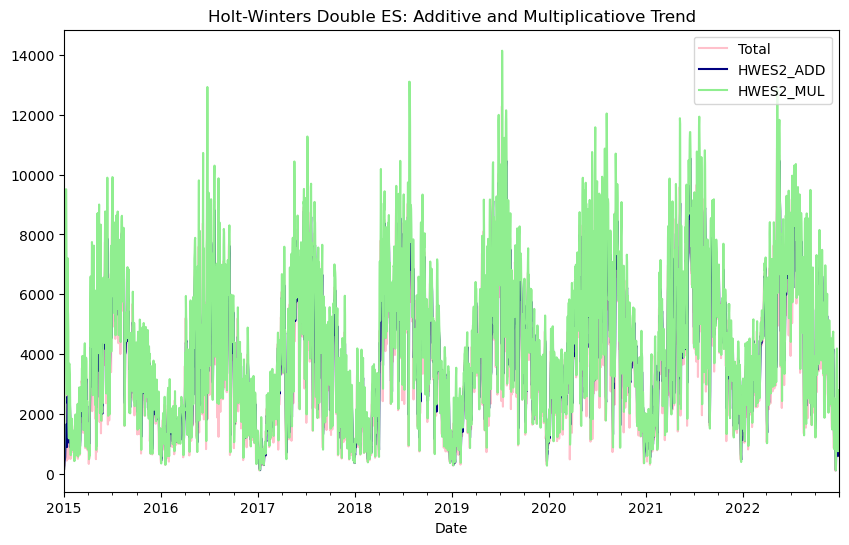

In [702]:
df_m_e_model['HWES2_ADD'] = ExponentialSmoothing(df_m_e_model['Total'], trend = 'add').fit().fittedvalues
df_m_e_model['HWES2_MUL'] = ExponentialSmoothing(df_m_e_model['Total'], trend = 'mul').fit().fittedvalues
df_m_e_model[['Total', 'HWES2_ADD', 'HWES2_MUL']].plot(title= 'Holt-Winters Double ES: Additive and Multiplicatiove Trend', color=['pink', 'navy', 'lightgreen'])

### Triple HWES

- airline[‘HWES3_ADD’] = ExponentialSmoothing(airline[‘Thousands of Passengers’],trend=’add’,seasonal=’add’,seasonal_periods=12).fit().
fittedvalues
- airline[‘HWES3_MUL’] = ExponentialSmoothing(airline[‘Thousands of Passengers’],trend=’mul’,seasonal=’mul’,seasonal_periods=12).fit().
fittedvalues
- airline[[‘Thousands of Passengers’,’HWES3_ADD’,’HWES3_MUL’]].plot(title=’Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality’);

/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: title={'center': 'Tripple HWES'}, xlabel='Date'>

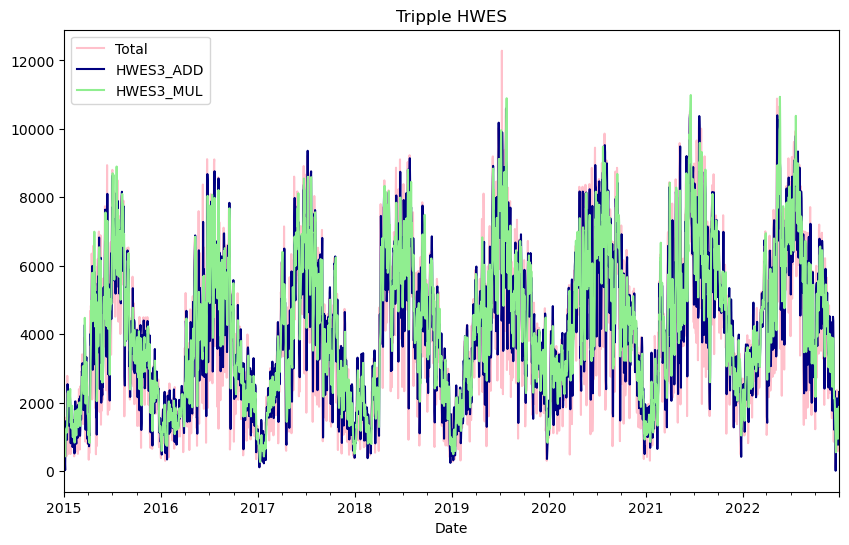

In [703]:
df_m_e_model['HWES3_ADD'] = ExponentialSmoothing(df_m_e_model['Total'], trend = 'add', seasonal= 'add', seasonal_periods= 12).fit().fittedvalues
df_m_e_model['HWES3_MUL'] = ExponentialSmoothing(df_m_e_model['Total'], trend = 'mul', seasonal= 'mul', seasonal_periods= 12).fit().fittedvalues

df_m_e_model[['Total', 'HWES3_ADD', 'HWES3_MUL']].plot(title='Tripple HWES', color=['pink', 'navy', 'lightgreen'])

In [704]:
df_m_e_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2015-01-01 to 2022-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Total      2922 non-null   float64
 1   HWES1      2922 non-null   float64
 2   HWES2_ADD  2922 non-null   float64
 3   HWES2_MUL  2922 non-null   float64
 4   HWES3_ADD  2922 non-null   float64
 5   HWES3_MUL  2922 non-null   float64
dtypes: float64(6)
memory usage: 159.8 KB


In [705]:
df_train = df_m_e_model['Total'].iloc[0:2400]
df_train.tail()
df_test = df_m_e_model['Total'].iloc[2400:]

/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Text(0.5, 1.0, 'Train, Test and Predicted')

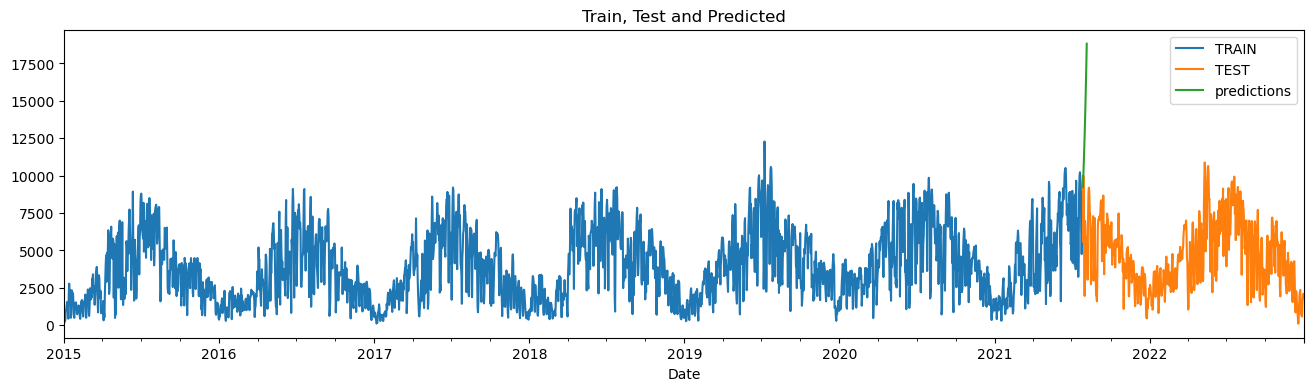

In [706]:
fitted_model =  ExponentialSmoothing(df_train, trend = 'mul', seasonal_periods=12).fit()
print(fitted_model)
# test_predictions = fitted_model.forecast(100)
predicted_values = fitted_model.forecast(steps=10)

df_train.plot(legend=True,label= 'TRAIN')
df_test.plot(legend=True,label='TEST',figsize=(16,4))
predicted_values.plot(legend=True, label='predictions')
plt.title('Train, Test and Predicted')

## Kreuther Location

In [707]:
# Calculate average temperature
df_location_kreuther['avg.temp'] = (df_location_kreuther['min.temp'] + df_location_kreuther['max.temp']) / 2

# Filter the DataFrame to include only rows with dates from 01.01.2015 until 31.03.2020
df_location_kreuther_before = df_location_kreuther[df_location_kreuther['datum'] <= '2020-03-31']

# Filter the DataFrame to include only rows with dates from 31.03.2020 until the latest one
df_location_kreuther_after = df_location_kreuther[df_location_kreuther['datum'] > '2020-03-31']

correlation_coef_k = df_location_kreuther['gesamt'].corr(df_location_kreuther['avg.temp'])
print("The overall correlation coefficient is: ", correlation_coef_k)

corr_coef_k_before = df_location_kreuther_before['gesamt'].corr(df_location_kreuther_before['avg.temp'])
corr_coef_k_after = df_location_kreuther_after['gesamt'].corr(df_location_kreuther_after['avg.temp'])
print("The correlation coefficient for before April 2020 is: ", corr_coef_k_before, ", and for after 2020: ", corr_coef_k_after, " with an average of: ", (corr_coef_k_after+corr_coef_k_before)/2)


KeyError: 'min.temp'

In [ ]:
# df_location_Hirsch.info()
#df_location_Olympia ## failure of the counting station in the Olympiapark from 15. June 2022 to the 31. August 2022
# df_location_Margareten.info()
# df_location_Arnulf.info() # For 2021, only data from 01.11.2021 and for 2019 from 01.06.2019 until 30.06.2019

In [ ]:

corr_coef_k_before = df_location_kreuther_before['gesamt'].corr(df_location_kreuther_before['niederschlag'])
corr_coef_k_after = df_location_kreuther_after['gesamt'].corr(df_location_kreuther_after['niederschlag'])
print("The correlation coefficient for the RAIN-BIKES relation before April 2020 is: ", corr_coef_k_before, ", and for after 2020: ", corr_coef_k_after, " with an average of: ", (corr_coef_k_after+corr_coef_k_before)/2)


The correlation coefficient for the RAIN-BIKES relation before April 2020 is:  -0.18942961948322726 , and for after 2020:  -0.13229384160288846  with an average of:  -0.16086173054305786


In [ ]:
df_location_erhardt = df_location_erhardt.rename(columns={'datum': 'Date', 'zaehlstelle': 'Location', 'gesamt':'Total', 'niederschlag':'Rainfall'})
df_location_erhardt.set_index('Date', inplace=True)

           Location  Total  min.temp  max.temp  Rainfall  avg.temp
Date                                                              
2015-01-01  Erhardt  137.0     -10.0       1.0       0.0      -4.0
2015-01-02  Erhardt  281.0     -12.0       4.0       6.0      -4.0
2015-01-03  Erhardt  269.0       0.0       4.0      26.0       2.0
2015-01-04  Erhardt  375.0       1.0       2.0       0.0       2.0
2015-01-05  Erhardt  976.0      -2.0       4.0       0.0       1.0


/Users/caropaez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/caropaez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/caropaez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/caropaez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

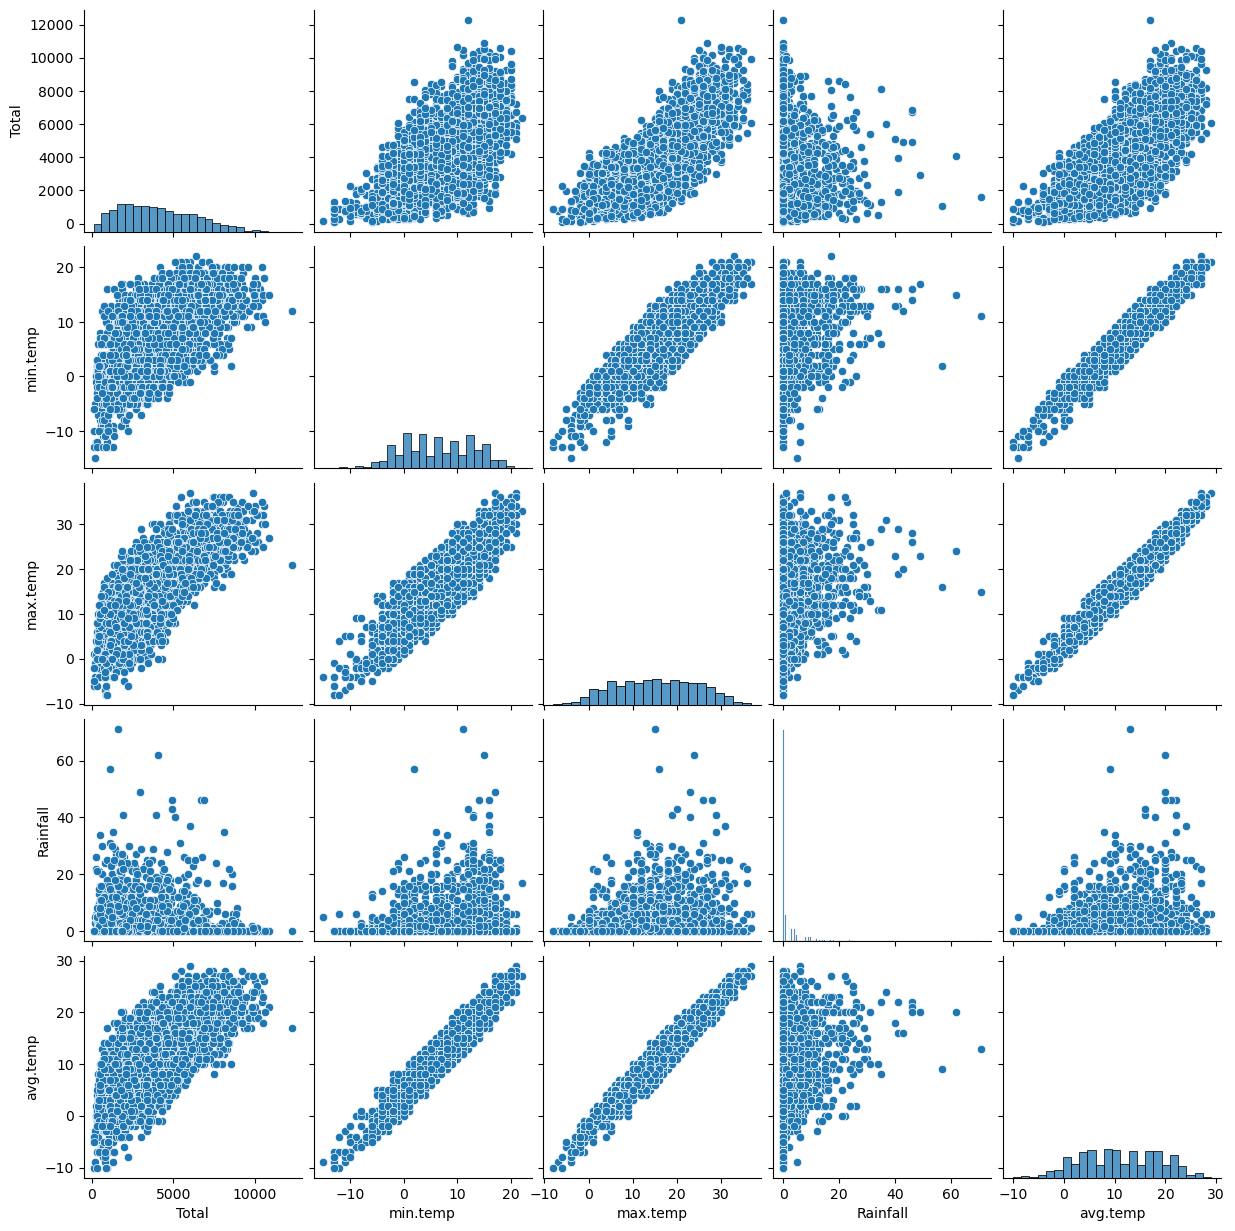

In [ ]:
print(df_location_erhardt.head())
sns.pairplot(df_location_erhardt)

### Checking if it is stationary or not for the Erhardt Location

In [ ]:
# Perform Augmented Dickey-Fuller test
# The ADF test is a statistical test commonly used to test for stationarity. 
# It tests the null hypothesis that a unit root is present in a time series sample. 
# If the p-value obtained from the test is less than a chosen significance level (e.g., 0.05), 
# you reject the null hypothesis, indicating that the data is stationary.
result = adfuller(df_location_erhardt['Total'])

# Print test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Print critical values
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

# Interpret results
if result[1] < 0.05:
    print('Reject the null hypothesis (non-stationary)')
else:
    print('Fail to reject the null hypothesis (stationary)')


ADF Statistic: -3.6698347228381016
p-value: 0.004558027689867485
Critical Values:
1%: -3.432612396049843
5%: -2.8625395742539688
10%: -2.5673021019579663
Reject the null hypothesis (non-stationary)
